Inputs:
- Shapefile

STAC search parameters:
- Time period
- Satellite sensor
- Target band indexes

Outputs:
- CSV containing a multiindex of zonal statistics for the specified polygons over the specified time period

In [ ]:
import zonalStatistics
import utilities

from importlib import reload
reload(utilities)
reload(zonalStatistics)

15

In [2]:
import rioxarray
import xarray as xr
# from dask.distributed import Client as DaskClient, LocalCluster
# import warnings
# warnings.filterwarnings('ignore')
# xr.set_options(keep_attrs=True);
# cluster = LocalCluster(n_workers=8, threads_per_worker=8)
# client = DaskClient(cluster); client

In [1]:
# Read shapefile as a GeoDataFrame
import geopandas as gpd
from pathlib import Path

# Path to the shapefile (relative to the repository root)
shp_path = Path("inputs/forest283Blackbutt/forest283.shp")

# Sanity check the path exists to give a clear error if not
if not shp_path.exists():
    raise FileNotFoundError(f"Shapefile not found: {shp_path.resolve()}")

# Read the shapefile
gdf = gpd.read_file(shp_path)

# Quick summary
print(f"Loaded {len(gdf)} features | CRS: {gdf.crs}")

gdf.head()

Loaded 858 features | CRS: EPSG:7844


,UNIT_KEY,PRUK,FOREST,LOG_AREA,CPT_ID,CPT_NO,SUB,SLASH,CPTCOMM,PRA,...,Shape__Are,Shape__Len,PRIM_SPEC_,SEC_SPEC_C,TCPT,SHORT_DESC,LOCATION,ST_ASSETID,T1GIS_ID,geometry
0,283_BIDWILLII_4_1,283_BIDWILLII_4,283,BIDWILLII,4,4,None,None,None,1,...,0.000010,0.020720,96,0,004,BIDWILLII_4_1,SF283\BIDWILLII\004,ST005076,5671,"POLYGON ((152.15976 -26.77157, 152.15978 -26.7..."
1,283_BIDWILLII_4_3,283_BIDWILLII_4,283,BIDWILLII,4,4,None,None,None,3,...,0.000003,0.008107,96,0,004,BIDWILLII_4_3,SF283\BIDWILLII\004,ST005078,6680,"POLYGON ((152.1705 -26.77303, 152.17048 -26.77..."
2,283_BIDWILLII_4_1,283_BIDWILLII_4,283,BIDWILLII,4,4,None,None,None,1,...,0.000025,0.042623,96,0,004,BIDWILLII_4_1,SF283\BIDWILLII\004,ST005076,5671,"POLYGON ((152.16206 -26.77525, 152.16215 -26.7..."
3,283_BIDWILLII_4_2,283_BIDWILLII_4,283,BIDWILLII,4,4,None,None,None,2,...,0.000004,0.007995,96,0,004,BIDWILLII_4_2,SF283\BIDWILLII\004,ST005077,10668,"POLYGON ((152.17142 -26.77423, 152.17141 -26.7..."
4,283_BIDWILLII_4_3,283_BIDWILLII_4,283,BIDWILLII,4,4,None,None,None,3,...,0.000004,0.008075,96,0,004,BIDWILLII_4_3,SF283\BIDWILLII\004,ST005078,6680,"POLYGON ((152.16735 -26.77325, 152.16752 -26.7..."


In [4]:
# Read shapefile as a GeoDataFrame
import geopandas as gpd
from pathlib import Path

gdf = gpd.read_file("inputs/sabre_bomgrid_within6km_of_plantation.geojson")
display(gdf.head())

,OBJECTID,CENTROID_X,CENTROID_Y,Orig_F_Wgt,New_CellID,FuelID,FuelDesc,sabre_ros,forest_fuel,grass,FMETimestamp,Shape_Length,Shape_Area,geometry
0,1,151.754679,-28.66,0,1245,1205,Grass - Eaten Out,Eaten Out Grass,21.495001,0.399,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.78449 -28.685, 151.78449 -28.635..."
1,2,151.814304,-28.66,0,1246,1144,McArthur,Forest,16.469000,0.330,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.84412 -28.685, 151.84412 -28.635..."
2,3,151.873929,-28.66,0,1247,1205,Grass - Eaten Out,Grazed Grass,21.495001,1.660,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.90374 -28.685, 151.90374 -28.635..."
3,4,151.695053,-28.61,0,1426,1138,Grass - Open Woodland,Woodland (<30% Canopy),4.049000,0.181,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.72487 -28.635, 151.72487 -28.585..."
4,5,151.754679,-28.61,0,1427,1144,McArthur,Forest,16.469000,0.525,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.78449 -28.635, 151.78449 -28.585..."


In [5]:
bbox = gdf.dissolve().total_bounds.tolist()

## Load in the STAC connection

In [1]:
from pystac_client import Client as StacClient
import planetary_computer

In [2]:
catalog = StacClient.open('https://planetarycomputer.microsoft.com/api/stac/v1/', modifier=planetary_computer.sign_inplace)
catalog

<Client id=microsoft-pc>

## Search the catalog for what we want

In [4]:
bbox = [140.0, -38.0, 145.0, -35.0]  # [min_lon, min_lat, max_lon, max_lat]

In [5]:
results = catalog.search(
    collections=['landsat-c2-l2'],
    bbox=bbox,
    datetime=['2024-06-01', '2025-06-30'],
    query={'eo:cloud_cover': {'lt': 20}, 'platform': {'in': ['landsat-8']}}
)
items = list(results.get_items())
len(items), items[0] if items else None

/Users/ben/miniconda3/envs/py312/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


(151, <Item id=LC08_L2SP_093085_20250628_02_T1>)

## Load data cube

In [6]:
from odc.stac import stac_load

bands = ['red','nir08']
chunks = {'time': 1, 'x': 1024, 'y': 1024}
data = stac_load(items=items, bands=bands, bbox=bbox, groupby='time', chunks=chunks)
data

<xarray.Dataset> Size: 104GB
Dimensions:      (y: 11330, x: 15213, time: 151)
Coordinates:
  * y            (y) float64 91kB -3.874e+06 -3.874e+06 ... -4.213e+06
  * x            (x) float64 122kB 4.088e+05 4.088e+05 ... 8.651e+05 8.651e+05
    spatial_ref  int32 4B 32654
  * time         (time) datetime64[ns] 1kB 2024-06-07T00:20:17.418303 ... 202...
Data variables:
    red          (time, y, x) uint16 52GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 52GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

## Aggregate to monthly

In [10]:
data_monthly = data.resample(time='1M').median()
data_monthly

c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 273GB
Dimensions:      (time: 13, y: 45181, x: 29088)
Coordinates:
  * y            (y) float64 361kB -1.834e+06 -1.834e+06 ... -3.19e+06 -3.19e+06
  * x            (x) float64 233kB 3.107e+05 3.107e+05 ... 1.183e+06 1.183e+06
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 104B 2024-06-30 2024-07-31 ... 2025-06-30
Data variables:
    red          (time, y, x) float64 137GB dask.array<chunksize=(1, 921, 921), meta=np.ndarray>
    nir08        (time, y, x) float64 137GB dask.array<chunksize=(1, 921, 921), meta=np.ndarray>

## Compute indicies

In [ ]:
nir = data_monthly['nir08']
red = data_monthly['red']
NDVI = (nir - red) / (nir + red)
# EVI = 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0)
# SAVI = (1.0 + 0.5) * (nir - red) / (nir + red + 0.5)
# In Landsat 8-9, SAVI = ((Band 5 – Band 4) / (Band 5 + Band 4 + 0.5)) * (1.5).
# NDVI, EVI, SAVI

NDVI

<xarray.DataArray (time: 13, y: 45181, x: 29088)> Size: 137GB
dask.array<truediv, shape=(13, 45181, 29088), dtype=float64, chunksize=(1, 921, 921), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 361kB -1.834e+06 -1.834e+06 ... -3.19e+06 -3.19e+06
  * x            (x) float64 233kB 3.107e+05 3.107e+05 ... 1.183e+06 1.183e+06
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 104B 2024-06-30 2024-07-31 ... 2025-06-30

## Plotting

In [14]:
# Efficient zonal statistics for all AOIs
from shapely.geometry import mapping as shp_mapping
import matplotlib.pyplot as plt
import pandas as pd

aoi_crs = gdf.crs or 'EPSG:4326'

# Method 1: Vectorized approach (most efficient)
def compute_zonal_stats_vectorized(ndvi_data, gdf):
    """Compute zonal statistics using vectorized operations"""
    records = []
    
    for idx, row in gdf[:10].iterrows():
        # Use UNIT_KEY column for labeling
        # name = row.get('UNIT_KEY')
        name = row.get('New_CellID')
        geoms = [shp_mapping(row.geometry)]
        
        # Clip and compute mean in one operation
        clipped = ndvi_data.rio.clip(geoms, aoi_crs, drop=True)
        
        # Compute spatial mean for each time step
        ndvi_timeseries = clipped.mean(dim=['y', 'x'])
        
        # Convert to DataFrame efficiently
        df_aoi = ndvi_timeseries.to_dataframe('value').reset_index()
        # df_aoi['unit_key'] = name  # Changed from 'aoi' to 'unit_key'
        df_aoi['New_CellID'] = name
        records.append(df_aoi)
    
    return pd.concat(records, ignore_index=True)

# Use the optimized function
df = compute_zonal_stats_vectorized(NDVI, gdf)

In [16]:
df.head()

,time,spatial_ref,value,New_CellID
0,2024-06-30,0,NaN,1245
1,2024-07-31,0,NaN,1245
2,2024-08-31,0,NaN,1245
3,2024-09-30,0,NaN,1245
4,2024-10-31,0,NaN,1245


Original records: 130
After cleaning: 0
Removed 130 invalid records


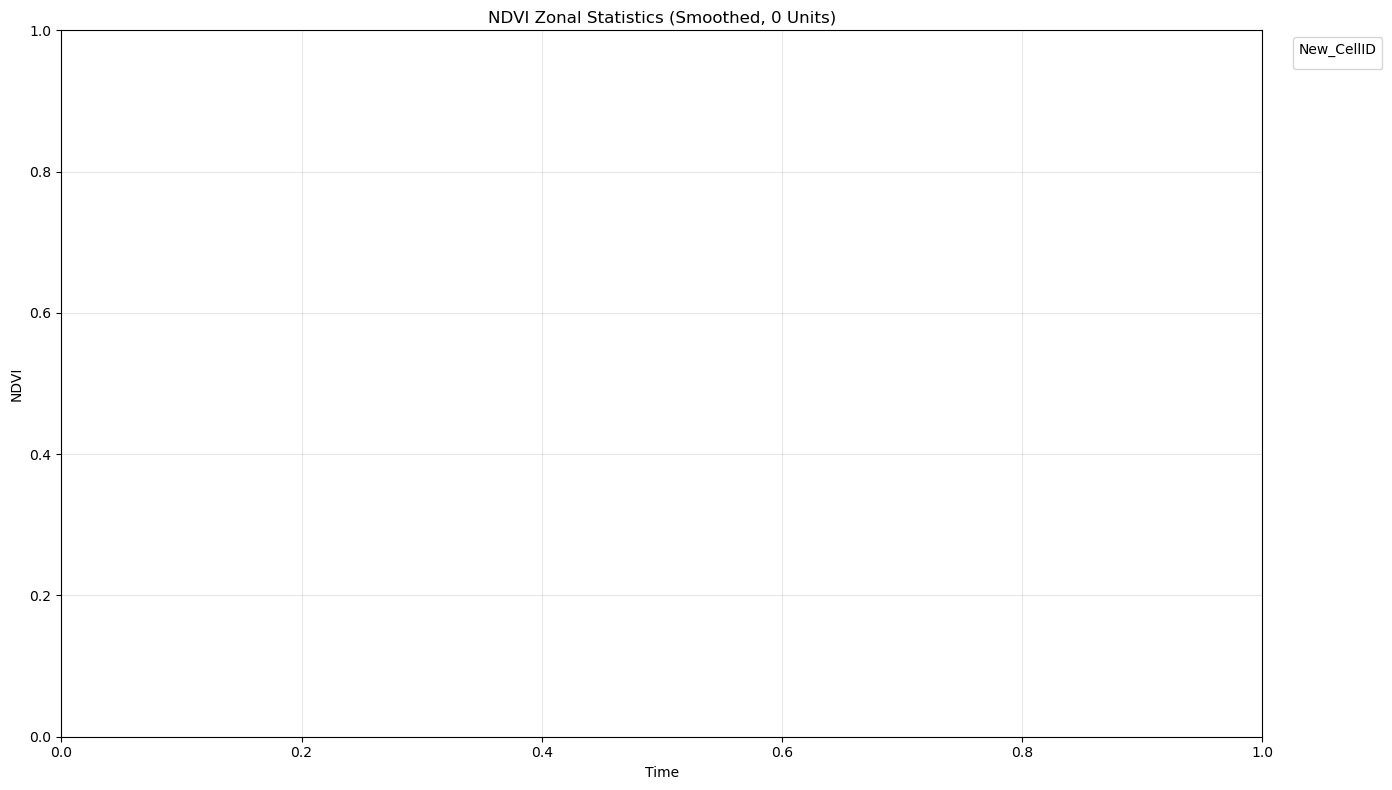

Plotted 0 units with cleaned data


In [17]:
# Clean the dataframe by removing zeros and nulls
df_cleaned = df.dropna(subset=['value'])  # Remove nulls
df_cleaned = df_cleaned[df_cleaned['value'] != 0]  # Remove zeros
df_cleaned = df_cleaned[df_cleaned['value'].between(-1, 1)]  # Remove invalid NDVI values

print(f"Original records: {len(df)}")
print(f"After cleaning: {len(df_cleaned)}")
print(f"Removed {len(df) - len(df_cleaned)} invalid records")

# Plot results with smoothing
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

fig, ax = plt.subplots(figsize=(14, 8))

# Fix duplicate entries by aggregating duplicates before pivoting
# df_clean = df_cleaned.groupby(['time', 'unit_key'])['value'].mean().reset_index()
# pivot = df_clean.pivot(index='time', columns='unit_key', values='value')

df_clean = df_cleaned.groupby(['time', 'New_CellID'])['value'].mean().reset_index()
pivot = df_clean.pivot(index='time', columns='New_CellID', values='value')

# Fill missing values with interpolation for continuous lines
pivot_filled = pivot.interpolate(method='time', limit_direction='both')

# Create smooth plots
for col in pivot_filled.columns:
    y_vals = pivot_filled[col].dropna()
    if len(y_vals) > 1:  # Need at least 2 points to plot
        x_vals = y_vals.index
        
        # Convert datetime to numeric for interpolation
        x_numeric = np.array([x.timestamp() for x in x_vals])
        
        # Create smooth interpolation if we have enough points
        if len(x_vals) >= 3:
            # Use cubic spline for smoothing
            f = interp1d(x_numeric, y_vals.values, kind='cubic', 
                        bounds_error=False, fill_value='extrapolate')
            
            # Create more points for smooth curve
            x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), len(x_numeric) * 3)
            x_smooth_dates = [pd.Timestamp.fromtimestamp(ts) for ts in x_smooth]
            y_smooth = f(x_smooth)
            
            ax.plot(x_smooth_dates, y_smooth, linewidth=2, alpha=0.8, label=col)
        else:
            # Fall back to simple line plot for insufficient data
            ax.plot(x_vals, y_vals, linewidth=2, alpha=0.8, label=col, marker='o')

ax.set_title(f'NDVI Zonal Statistics (Smoothed, {len(pivot_filled.columns)} Units)')
ax.set_ylabel('NDVI')
ax.set_xlabel('Time')
ax.grid(True, alpha=0.3)
# plt.legend(title='Unit Key', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.legend(title='New_CellID', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"Plotted {len(pivot_filled.columns)} units with cleaned data")

In [18]:
print(f"Processed {len(gdf)} units with {len(df)} total records")
print(f"Unique units: {df['unit_key'].unique()}")
df.head()

# Export individual CSV files for each UNIT_KEY
from pathlib import Path

# Create outputs directory if it doesn't exist
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True)

# Export CSV for each unique UNIT_KEY
for unit_key in df['unit_key'].unique():
    if pd.notna(unit_key):  # Skip any NaN values
        # Filter data for this unit
        unit_data = df[df['unit_key'] == unit_key][['time', 'value']].copy()
        unit_data = unit_data.sort_values('time')
        
        # Create filename (sanitize unit_key for filesystem)
        safe_unit_key = str(unit_key).replace('/', '_').replace('\\', '_').replace(' ', '_')
        filename = f"NDVI_{safe_unit_key}.csv"
        filepath = outputs_dir / filename
        
        # Export to CSV
        unit_data.to_csv(filepath, index=False)
        print(f"Exported: {filepath}")

print(f"\nExported {len(df['unit_key'].unique())} CSV files to {outputs_dir.resolve()}")

# Also export combined CSV with all units
combined_filepath = outputs_dir / "NDVI_all_units.csv"
df[['time', 'unit_key', 'value']].to_csv(combined_filepath, index=False)
print(f"Exported combined data: {combined_filepath}")

Processed 858 units with 1080 total records
Unique units: ['283_BIDWILLII_4_1' '283_BIDWILLII_4_3' '283_BIDWILLII_4_2'
 '283_BIDWILLII_4_4' '283_BIDWILLII_4_6']
Exported: outputs/NDVI_283_BIDWILLII_4_1.csv
Exported: outputs/NDVI_283_BIDWILLII_4_3.csv
Exported: outputs/NDVI_283_BIDWILLII_4_2.csv
Exported: outputs/NDVI_283_BIDWILLII_4_4.csv
Exported: outputs/NDVI_283_BIDWILLII_4_6.csv

Exported 5 CSV files to /Users/ben/Library/CloudStorage/OneDrive-HQPLANTATIONSPTYLTD/Documents/code/my_code/satellite-data-toolbox/outputs
Exported combined data: outputs/NDVI_all_units.csv


## Weather

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Read the weather station data
weather_data = pd.read_csv('inputs/40020.csv')

# Display the first few rows to understand the structure
print("Weather data structure:")
print(weather_data.head())

Weather data structure:
       Date  Day  T.Max  Smx  T.Min  Smn  Rain  Srn  Evap  Sev  Radn  Ssl  \
0  20100101    1   27.1   25   19.0   25   2.4    0   2.7   25  13.2   42   
1  20100102    2   28.9   25   20.0   25   2.2    0   4.1   25  18.4   42   
2  20100103    3   30.6   25   21.3   25   0.8    0   5.9   25  15.9   42   
3  20100104    4   25.0   25   20.6   25  12.0    0   2.7   25   9.8   42   
4  20100105    5   24.4   25   18.3   25   1.2    0   2.0   25  13.3   42   

     VP  Svp  RHmaxT  RHminT       Date2  
0  19.5   25    54.4    88.8   1/01/2010  
1  22.1   25    55.5    94.6   2/01/2010  
2  24.0   25    54.7    94.8   3/01/2010  
3  21.7   25    68.5    89.5   4/01/2010  
4  20.6   25    67.4    98.0   5/01/2010  


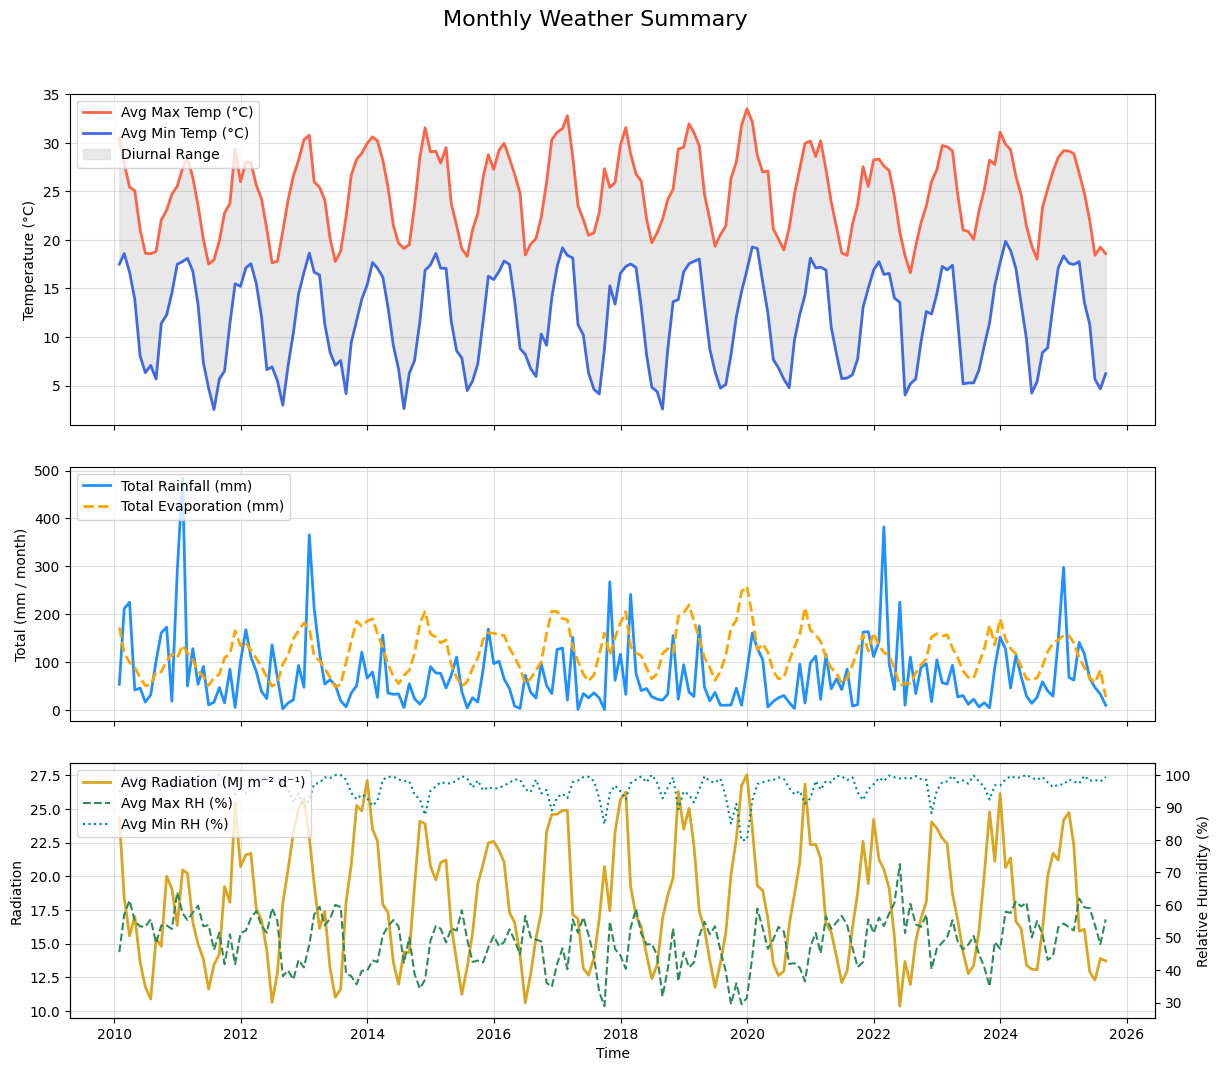

In [73]:
# Weather-only combined plots (monthly aggregates)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

wd = weather_data.copy()

# --- Data Preparation ---

# Detect and parse date column (prefer Date2, else Date as YYYYMMDD)
date_col = None
if 'Date2' in wd.columns:
    wd['Date2'] = pd.to_datetime(wd['Date2'].astype(str).str.strip(), dayfirst=True, errors='coerce')
    if wd['Date2'].notna().any():
        date_col = 'Date2'

if date_col is None and 'Date' in wd.columns:
    # Try integer/str YYYYMMDD format
    wd['Date'] = pd.to_datetime(wd['Date'].astype(str).str.strip(), format='%Y%m%d', errors='coerce')
    if wd['Date'].notna().any():
        date_col = 'Date'

if date_col is None:
    # Fallback: try parsing the first column
    c0 = wd.columns[0]
    wd[c0] = pd.to_datetime(wd[c0], errors='coerce', dayfirst=True)
    if wd[c0].notna().any():
        date_col = c0
    else:
        raise ValueError("Could not automatically detect or parse a date column.")

# Set index and convert all other columns to numeric
wd = wd[wd[date_col].notna()].sort_values(date_col).set_index(date_col)
for c in wd.columns:
    if c != date_col:
        wd[c] = pd.to_numeric(wd[c], errors='coerce')

# --- Monthly Aggregation ---

# Select relevant weather variables that are present in the file
wanted = ['T.Max','T.Min','Rain','Evap','Radn','VP','RHmaxT','RHminT']
present = [c for c in wanted if c in wd.columns]

# Define aggregation rules for monthly resampling
agg_map = {
    'Rain': 'sum',
    'Evap': 'sum',
    'T.Max': 'mean',
    'T.Min': 'mean',
    'Radn': 'mean',
    'VP': 'mean',
    'RHmaxT': 'mean',
    'RHminT': 'mean',
}
monthly = wd[present].resample('1M').agg({c: agg_map.get(c, 'mean') for c in present})

# --- Plotting ---

# Prepare figure with 3 stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, sharex=True, figsize=(14, 12),
    gridspec_kw={'height_ratios': [1.3, 1.0, 1.0], 'hspace': 0.15}
)
fig.suptitle('Monthly Weather Summary', fontsize=16, y=0.95)

# Subplot 1: Temperature
if 'T.Max' in monthly.columns:
    ax1.plot(monthly.index, monthly['T.Max'], color='tomato', lw=2, label='Avg Max Temp (°C)')
if 'T.Min' in monthly.columns:
    ax1.plot(monthly.index, monthly['T.Min'], color='royalblue', lw=2, label='Avg Min Temp (°C)')
if all(c in monthly.columns for c in ['T.Max','T.Min']):
    ax1.fill_between(monthly.index, monthly['T.Min'], monthly['T.Max'], color='lightgray', alpha=0.5, label='Diurnal Range')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True, alpha=0.4)
ax1.legend(loc='upper left')

# Subplot 2: Rain + Evaporation
if 'Rain' in monthly.columns:
    ax2.plot(monthly.index, monthly['Rain'], color='dodgerblue', lw=2, label='Total Rainfall (mm)')
if 'Evap' in monthly.columns:
    ax2.plot(monthly.index, monthly['Evap'], color='orange', lw=2, ls='--', label='Total Evaporation (mm)')
ax2.set_ylabel('Total (mm / month)')
ax2.grid(True, alpha=0.4)
ax2.legend(loc='upper left')

# Subplot 3: Radiation + RH/VP on a secondary axis
ax3_right = ax3.twinx() # Create secondary y-axis
if 'Radn' in monthly.columns:
    ax3.plot(monthly.index, monthly['Radn'], color='goldenrod', lw=2, label='Avg Radiation (MJ m⁻² d⁻¹)')
ax3.set_ylabel('Radiation')

if 'RHmaxT' in monthly.columns:
    ax3_right.plot(monthly.index, monthly['RHmaxT'], color='seagreen', lw=1.5, ls='--', label='Avg Max RH (%)')
if 'RHminT' in monthly.columns:
    ax3_right.plot(monthly.index, monthly['RHminT'], color='darkcyan', lw=1.5, ls=':', label='Avg Min RH (%)')
ax3_right.set_ylabel('Relative Humidity (%)')

ax3.grid(True, alpha=0.4)
ax3.set_xlabel('Time')

# Combine legends for the third plot
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_right.get_legend_handles_labels()
ax3_right.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
plt.show()